<a href="https://www.kaggle.com/code/rishitjakharia/uci-har?scriptVersionId=211996376" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
from numpy import mean, std, dstack

import seaborn as sns
import matplotlib.pyplot as plt 

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, LSTM, TimeDistributed, Permute, Reshape, Conv1D, MaxPooling1D, Activation
from keras.layers import Add, Layer, GlobalAveragePooling1D, GlobalMaxPool1D, BatchNormalization, Bidirectional, Multiply, Add, Concatenate

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

from sklearn import metrics
from sklearn.metrics import classification_report

import pandas as pd
from pandas import read_csv

In [2]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# os.environ['TF_DETERMINISTIC_OPS'] = '1' # Causes errors with MaxPooling Layer since XLA Implementation is not present in a deterministic fashion

# Loading Dataset

In [3]:
train = pd.read_csv('/kaggle/input/har-using-deep-nn/train.csv')
train.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
4525,0.283203,-0.047024,-0.168986,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,...,-0.034924,0.558036,0.258975,-0.854858,-0.78433,0.22296,-0.066506,22,3,WALKING_DOWNSTAIRS


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('/kaggle/input/har-using-deep-nn/test.csv')
test.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
718,0.3659,-0.031332,-0.024079,0.183421,-0.344568,-0.403268,0.09989,-0.3422,-0.412337,0.4803,...,-0.37837,-0.840289,-0.864326,0.848585,-0.960939,0.116422,-0.003858,9,3,WALKING_DOWNSTAIRS


In [6]:
test.shape

(2947, 564)

In [7]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


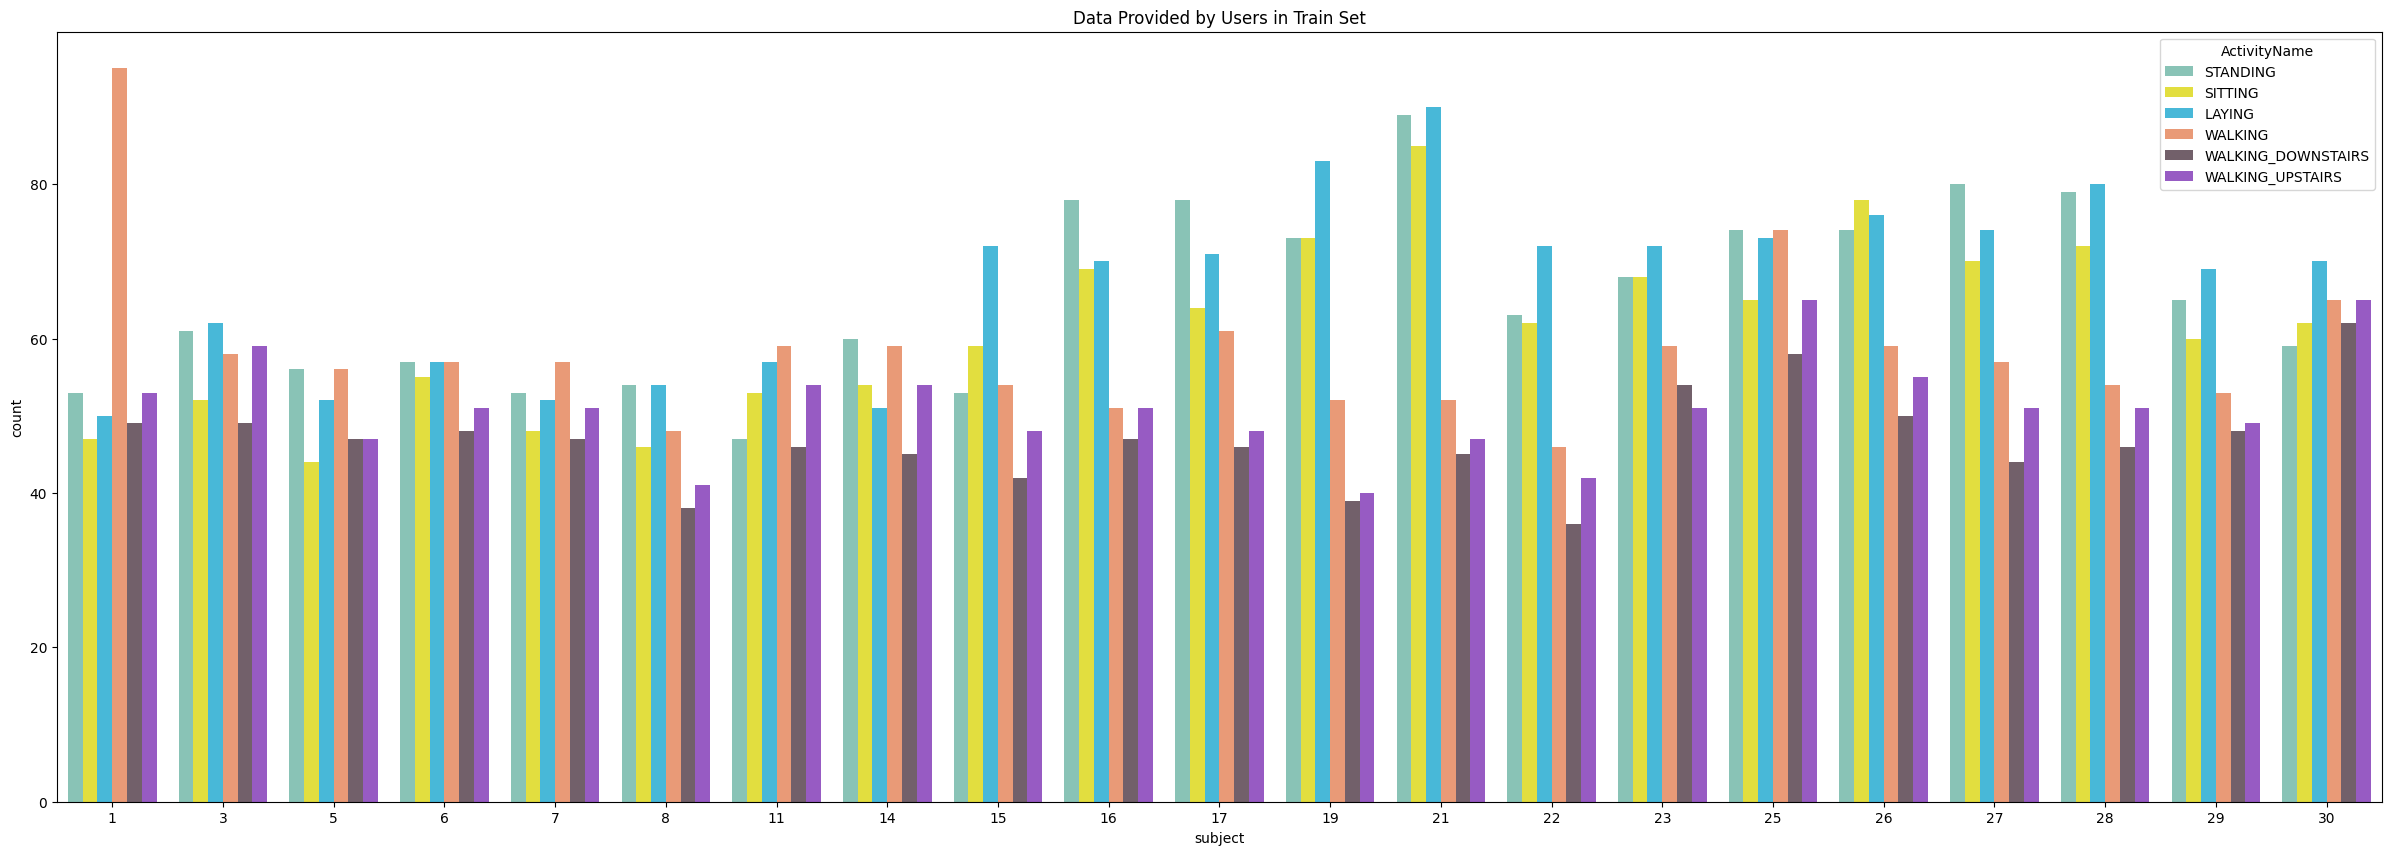

In [8]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
plt.title('Data Provided by Users in Train Set')
plt.show()

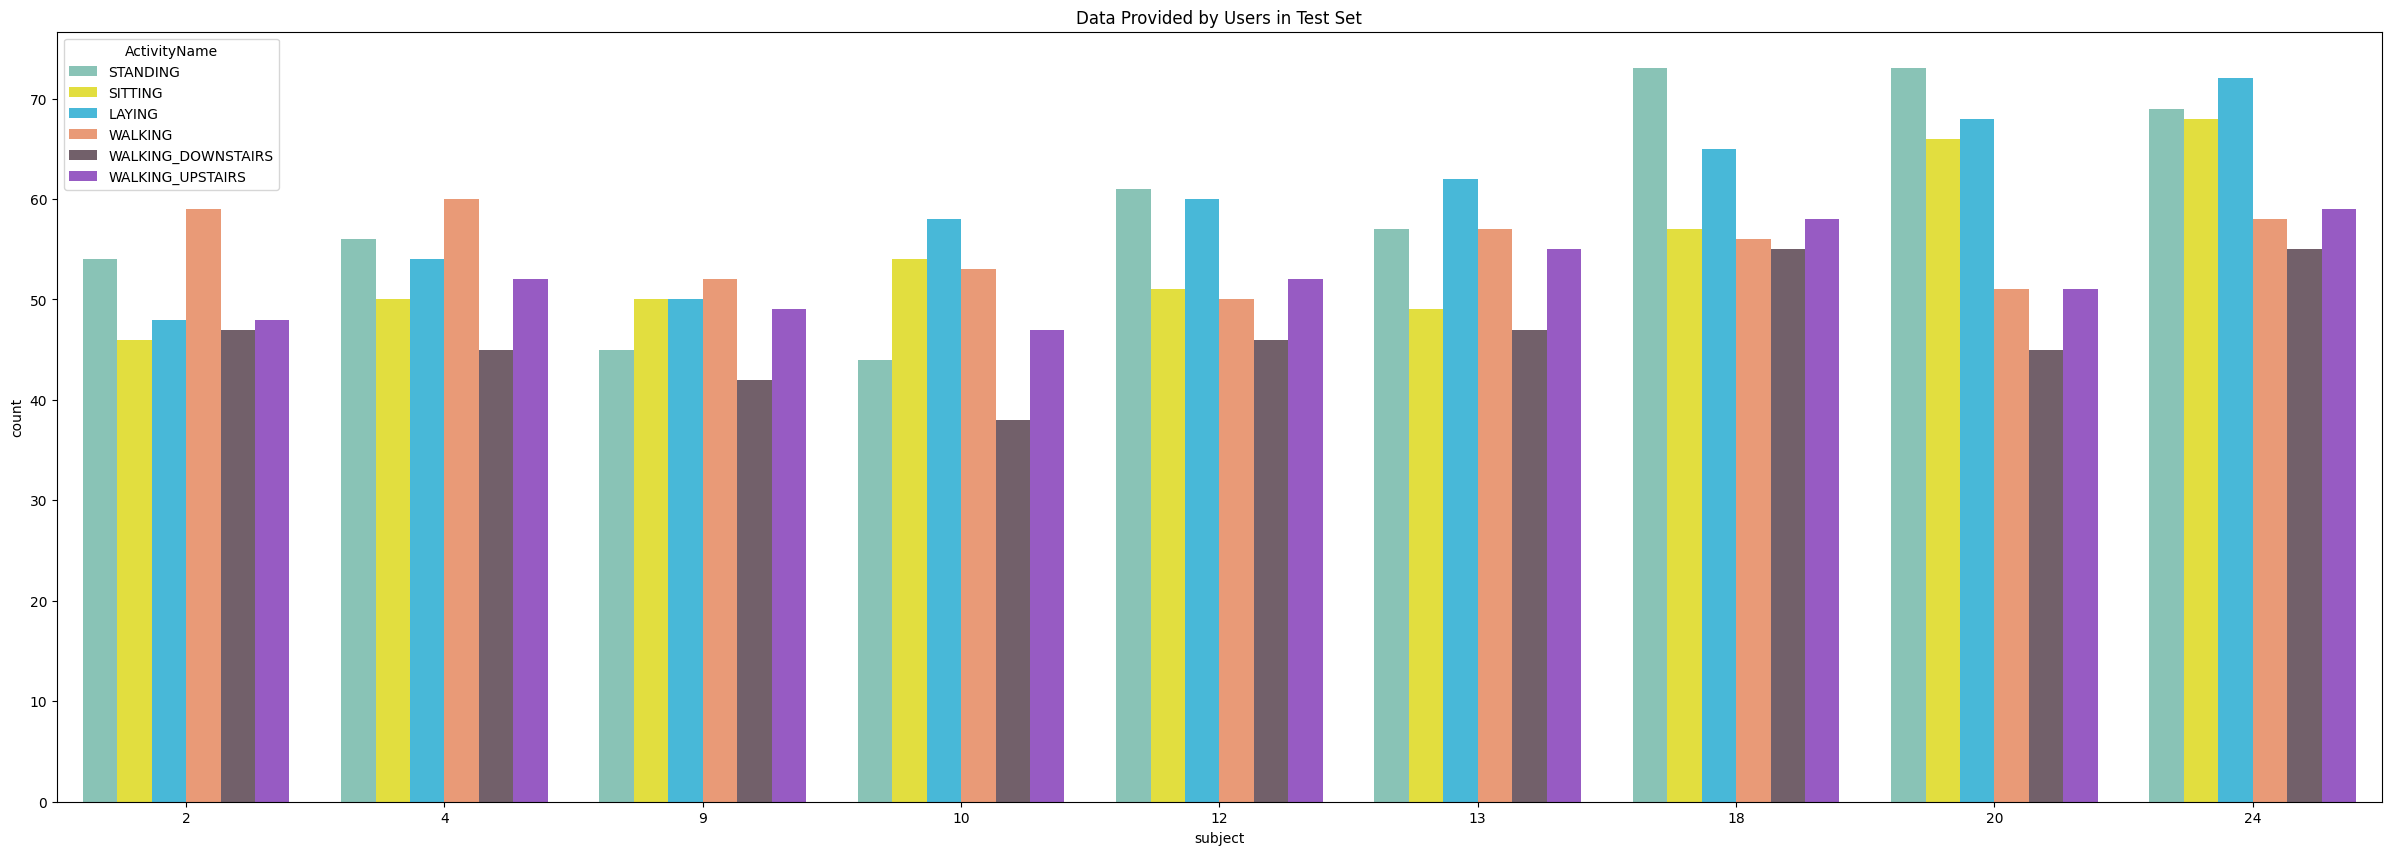

In [9]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
plt.title('Data Provided by Users in Test Set')
plt.show()

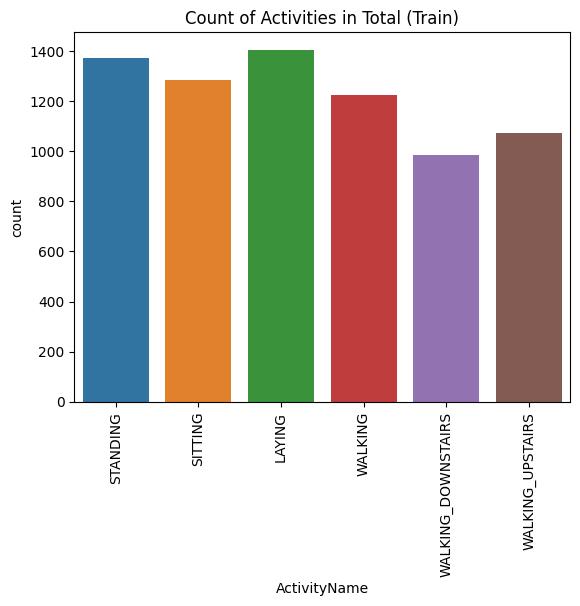

In [10]:
plt.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
plt.xticks(rotation=90)
plt.show()

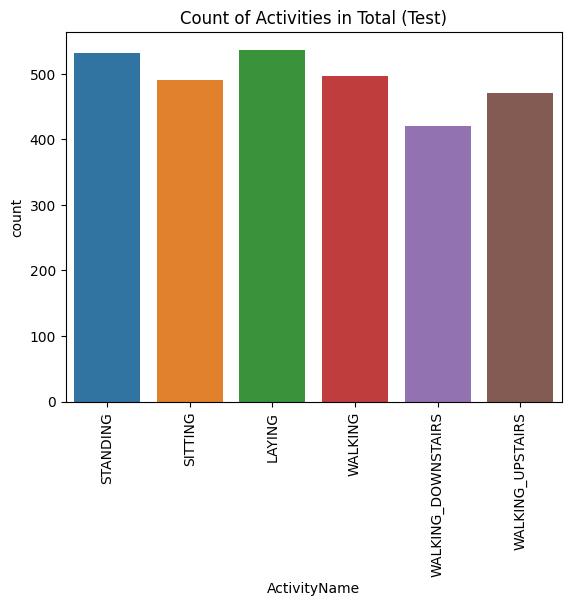

In [11]:
plt.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
plt.xticks(rotation=90)
plt.show()

In [12]:
def file_load(filepath):
    df = read_csv(filepath, header=None, sep='\s+')
    return df.values

In [13]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = dstack(datalist)
    return datalist

In [14]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [15]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [16]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 100, 200
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
n_steps = 4
n_length = 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 4, 32, 9) (2947, 4, 32, 9)


# Model Training

## ConvLSTM

In [17]:
# Define input shape
input_shape = (None, n_length, n_features)
inputs = Input(shape=input_shape)

# CNN feature extraction part
cnn = TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'))(inputs)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'))(cnn)
cnn = TimeDistributed(Dropout(0.5))(cnn)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Flatten())(cnn)

# LSTM part
# Adjust LSTM units
lstm = LSTM(128)(cnn)
lstm = tf.keras.layers.BatchNormalization()(lstm)
lstm = Dropout(0.3)(lstm)
lstm = Dense(128, activation='relu')(lstm)
lstm = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(lstm)
output = Dense(n_outputs, activation='softmax')(lstm)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [18]:
history=model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=0)

In [19]:
loss , accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

# print(model.summary()) 

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 92.05971956253052


In [20]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


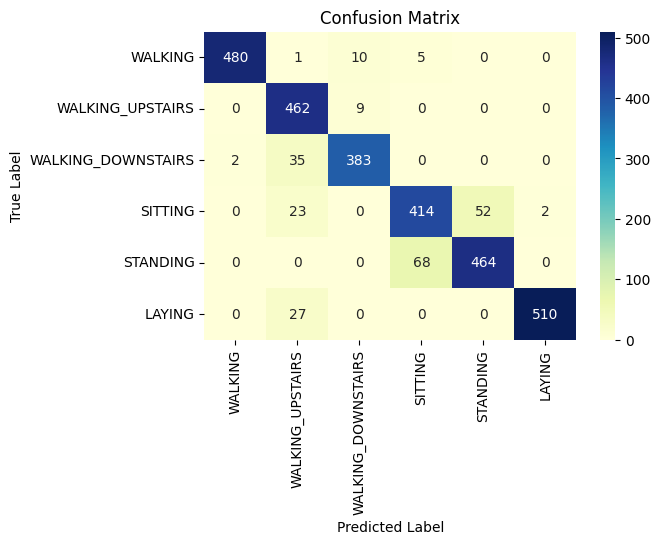

In [21]:
ypred_train = model.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = model.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## ConvBi-LSTM

In [22]:
input_shape = (None, n_length, n_features)  
inputs = Input(shape=input_shape)

# CNN feature extraction part
cnn = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(inputs)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'))(cnn)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Dropout(0.5))(cnn)
cnn = TimeDistributed(Flatten())(cnn)

# RNN part 
rnn = Bidirectional(LSTM(128, return_sequences=False))(cnn)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.3)(rnn)

# Dense layers for classification
dense = Dense(128, activation='relu')(rnn)
dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense)
output = Dense(n_outputs, activation='softmax')(dense)

# Create the model
rcnn_model = Model(inputs=inputs, outputs=output)

# Compile the model
rcnn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

rcnn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 32, 9)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, None, 30, 64)   │         1,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, None, 15, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, None, 13, 128)  │        24,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, None, 6, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, None, 6, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, None, 768)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 987,590 (3.77 MB)

 Trainable params: 987,078 (3.77 MB)

 Non-trainable params: 512 (2.00 KB)

In [23]:
history=rcnn_model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=0)

In [24]:
loss , accuracy = rcnn_model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 93.79029273986816


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


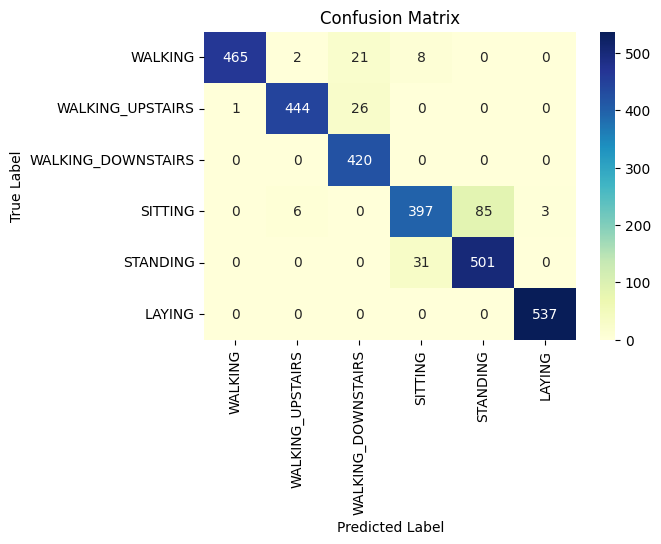

In [25]:
ypred_train = rcnn_model.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = rcnn_model.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## TCN

In [16]:
# !pip install keras-tcn --no-dependencies 

In [26]:
def tcn_block(inputs, filters, kernel_size, dilation_rate):
    # Causal convolution
    conv1 = Conv1D(filters, kernel_size, padding='causal', 
                   dilation_rate=dilation_rate, activation='relu')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    
    # Residual connection
    if inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1)(inputs)
    else:
        shortcut = inputs
    
    output = Add()([conv1, shortcut])
    return output

def create_tcn_model(n_length, n_features, n_outputs):
    inputs = Input(shape=(n_length, n_features))
    
    # TCN-like layers
    x = inputs
    for dilation in [1, 2, 4, 8]:
        x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=dilation)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    # Output layer
    output = Dense(n_outputs, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

X_tcn = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2] ,trainX.shape[3])
X_test_tcn = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2] ,testX.shape[3])

n_length = X_tcn.shape[1]
n_features = X_tcn.shape[2]
n_outputs = trainy.shape[1]

tcn_model = create_tcn_model(n_length, n_features, n_outputs)
print(tcn_model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │      1,792 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 64)   │        640 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 128, 64)   │     12,352 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 128, 64)   │     12,352 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 64)   │     12,352 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 6)         │        390 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,478 (224.52 KB)

 Trainable params: 56,966 (222.52 KB)

 Non-trainable params: 512 (2.00 KB)

None


In [27]:
history=tcn_model.fit(X_tcn, trainy, validation_data=(X_test_tcn, testy), epochs=epochs, batch_size=batch_size, verbose=0)

I0000 00:00:1733719854.551939      92 service.cc:145] XLA service 0x7f7a6e0b2160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733719854.551989      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733719858.082261      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [28]:
loss , accuracy = tcn_model.evaluate(X_test_tcn, testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 94.02782320976257


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


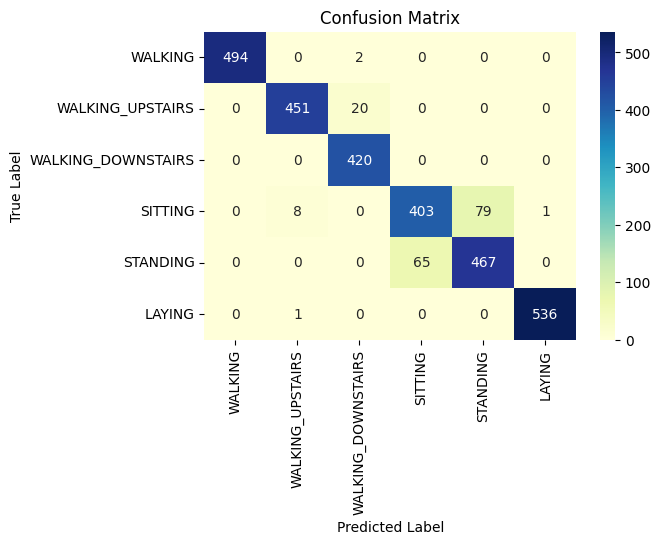

In [29]:
ypred_train = tcn_model.predict(X_tcn)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = tcn_model.predict(X_test_tcn)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Trynig out some other models

### Attention 

In [30]:
def adaptive_rnn(n_timesteps, n_features, n_outputs):
    # Adjust input shape to be 3D (timesteps, features)
    inputs = Input(shape=(n_timesteps, n_features))
    
    # LSTM layer (Bidirectional LSTM)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = BatchNormalization()(lstm_out)
    
    # Attention mechanism to weigh timesteps
    attention_scores = Dense(1, activation='sigmoid')(lstm_out)  # Attention weights
    attention_scores = Multiply()([lstm_out, attention_scores])  # Weighted timesteps
    
    # Global average pooling (summarizing attended features)
    x = tf.keras.layers.GlobalAveragePooling1D()(attention_scores)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    # Output layer
    output = Dense(n_outputs, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

n_timesteps = 32*4  
n_features = 9
n_outputs = 6  

adapt_rnn = adaptive_rnn(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs)
print(adapt_rnn.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128, 256)  │    141,312 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256)  │      1,024 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128, 1)    │        257 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 256)  │          0 │ batch_normalizat… │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 6)         │        390 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184,135 (719.28 KB)

 Trainable params: 183,623 (717.28 KB)

 Non-trainable params: 512 (2.00 KB)

None


In [31]:
history=adapt_rnn.fit(trainX.reshape(-1, 32*4, 9), trainy, validation_data=(testX.reshape(-1, 32*4, 9), testy), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5743 - loss: 2.0166 - val_accuracy: 0.3163 - val_loss: 2.1852
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8788 - loss: 0.8841 - val_accuracy: 0.6135 - val_loss: 1.6488
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9347 - loss: 0.5452 - val_accuracy: 0.8151 - val_loss: 1.2042
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9420 - loss: 0.3953 - val_accuracy: 0.8826 - val_loss: 0.9026
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9454 - loss: 0.3057 - val_accuracy: 0.8931 - val_loss: 0.7753
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9499 - loss: 0.2495 - val_accuracy: 0.8945 - val_loss: 0.6320
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9507 - loss: 0.2077 - val_accuracy: 0.9016 - val_loss: 0.4734
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9536 - loss: 0.1843 - val_accuracy: 0.

In [32]:
loss , accuracy = adapt_rnn.evaluate(testX.reshape(-1, 32*4, 9), testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 94.87614631652832


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


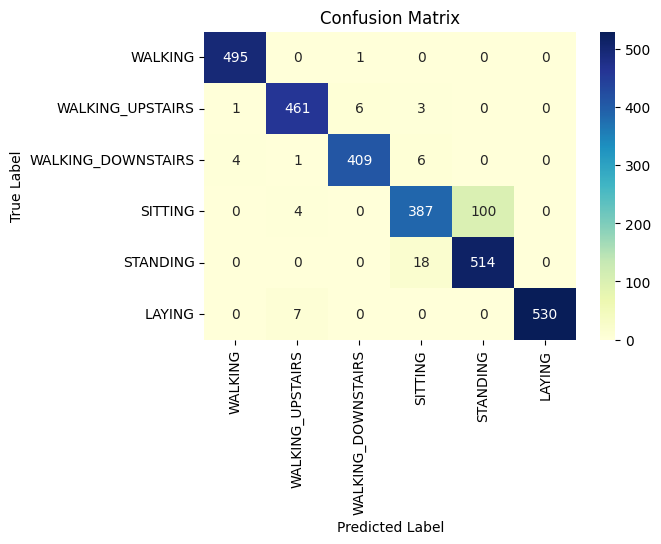

In [33]:
ypred_train = adapt_rnn.predict(trainX.reshape(-1, 32*4, 9))
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = adapt_rnn.predict(testX.reshape(-1, 32*4, 9))
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Inception and Resnet like conv layers

In [36]:
def create_model(n_length, n_features, n_outputs):
    input_shape = (None, n_length, n_features)  # Shape: (batch_size, time_steps, features)
    inputs = Input(shape=input_shape)

    # --- Inception-like block ---
    # Multiple branches with different kernel sizes (1, 3, 5)
    inception_branch1 = TimeDistributed(Conv1D(filters=16, kernel_size=1, activation='relu', padding='same'))(inputs)
    inception_branch2 = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))(inputs)
    inception_branch3 = TimeDistributed(Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'))(inputs)

    # Concatenate the branches
    inception_output = Concatenate()([inception_branch1, inception_branch2, inception_branch3])

    # --- ResNet-like block ---
    # First convolution in ResNet block
    resnet_conv1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))(inception_output)
    resnet_conv2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))(resnet_conv1)
    
    # Add the input (skip connection)
    resnet_output = Add()([inception_output, resnet_conv2])

    # --- CNN Layer (after Inception and ResNet blocks) ---
    cnn = TimeDistributed(MaxPooling1D(pool_size=2))(resnet_output)
    cnn = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'))(cnn)
    cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
    cnn = TimeDistributed(Dropout(0.3))(cnn)
    cnn = TimeDistributed(Flatten())(cnn)

    # --- RNN part ---
    rnn = Bidirectional(LSTM(128, return_sequences=False))(cnn)
    rnn = BatchNormalization()(rnn)
    rnn = Dropout(0.3)(rnn)

    # --- Dense layers for classification ---
    dense = Dense(128, activation='relu')(rnn)
    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense)
    output = Dense(n_outputs, activation='softmax')(dense)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

# Example Usage
n_length = 32
n_features = 9 
n_outputs = 6  

res_ception_lstm = create_model(n_length, n_features, n_outputs)
res_ception_lstm.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None, 32,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, None, 32,  │        160 │ input_layer_5[0]… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, None, 32,  │        896 │ input_layer_5[0]… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, None, 32,  │        736 │ input_layer_5[0]… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 32,  │          0 │ time_distributed… │
│ (Concatenate)       │ 64)               │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, None, 32,  │     12,352 │ concatenate_1[0]… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, None, 32,  │     12,352 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None, 32,  │          0 │ concatenate_1[0]… │
│                     │ 64)               │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, None, 16,  │          0 │ add_5[0][0]       │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, None, 14,  │     24,704 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, None, 7,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, None, 7,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, None, 896) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │  1,049,600 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     32,896 │ dropout_9[0][0] 

 Total params: 1,143,366 (4.36 MB)

 Trainable params: 1,142,854 (4.36 MB)

 Non-trainable params: 512 (2.00 KB)

In [37]:
history=res_ception_lstm.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.6810 - loss: 1.6118 - val_accuracy: 0.5260 - val_loss: 2.1007
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9261 - loss: 0.8205 - val_accuracy: 0.5918 - val_loss: 1.6089
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9474 - loss: 0.5939 - val_accuracy: 0.8588 - val_loss: 1.1704
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9526 - loss: 0.4390 - val_accuracy: 0.8626 - val_loss: 0.9626
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9512 - loss: 0.3379 - val_accuracy: 0.8755 - val_loss: 0.7418
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9533 - loss: 0.2684 - val_accuracy: 0.8918 - val_loss: 0.6017
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9538 - loss: 0.2195 - val_accuracy: 0.8873 - val_loss: 0.4934
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9573 - loss: 0.1842 - val_accuracy: 0.

In [38]:
loss , accuracy = res_ception_lstm.evaluate(testX, testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 93.2813048362732


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


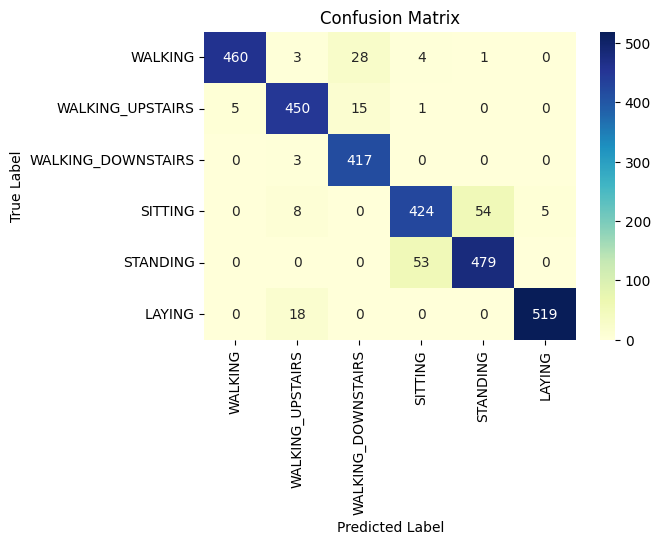

In [39]:
ypred_train = res_ception_lstm.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = res_ception_lstm.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### CBAM - Convolutional block Attention Module

Comparing CBAM as standalone pure CNNs and as features extraction mechanisms with LSTMs

#### ResBlock + CBAM

Implementation Convolutional Block Attention Module (CBAM) with Residual block (Tensorflow2 & Keras)

This snippet code is a part of the Super AI Engineer article

Author: Suesarn Wilainuch (22p21c0153)

Ho�🟢🔵
"""

In [27]:
# def cbam_block(inputs, filter_num=[64, 128, 128], reduction_ratio=8, stride=1):
#     x = inputs
    
#     # Channel Attention Module
#     x = Conv1D(filter_num[0], kernel_size=1, strides=stride, padding='same')(x)
#     x = BatchNormalization(axis=-1)(x)
#     x = Activation('relu')(x)

#     x = Conv1D(filter_num[1], kernel_size=3, strides=1, padding='same')(x)
#     x = BatchNormalization(axis=-1)(x)

#     avgpool = GlobalAveragePooling1D()(x)
#     maxpool = GlobalMaxPool1D()(x)

#     dense1 = Dense(filter_num[2] // reduction_ratio, activation='relu')
#     dense2 = Dense(filter_num[2], activation='relu')

#     avg_out = dense2(dense1(avgpool))
#     max_out = dense2(dense1(maxpool))

#     channel = Add()([avg_out, max_out])
#     channel = Activation('sigmoid')(channel)
#     channel = Reshape((1, filter_num[2]))(channel)
#     channel_out = Multiply()([x, channel])

#     # Spatial Attention Module
#     avgpool = tf.reduce_mean(channel_out, axis=-1, keepdims=True)
#     maxpool = tf.reduce_max(channel_out, axis=-1, keepdims=True)
#     spatial = Concatenate(axis=-1)([avgpool, maxpool])

#     spatial = Conv1D(1, kernel_size=7, strides=1, padding='same')(spatial)
#     spatial_out = Activation('sigmoid')(spatial)

#     CBAM_out = Multiply()([channel_out, spatial_out])

#     # Residual connection
#     residual = Conv1D(filter_num[2], kernel_size=1, strides=stride, padding='same')(inputs)
#     output = Add()([CBAM_out, residual])
#     output = Activation('relu')(output)

#     return output

class CBAM(Layer):
    def __init__(self, filter_num=[64, 128, 128], reduction_ratio=8, stride=1, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.filter_num = filter_num
        
        # Create layers only once in the constructor
        self.conv1 = Conv1D(filter_num[0], kernel_size=1, strides=stride, padding='same')
        self.bn1 = BatchNormalization(axis=-1)
        self.relu = Activation('relu')

        self.conv2 = Conv1D(filter_num[1], kernel_size=3, strides=1, padding='same')
        self.bn2 = BatchNormalization(axis=-1)

        self.dense1 = Dense(filter_num[2] // reduction_ratio, activation='relu')
        self.dense2 = Dense(filter_num[2], activation='relu')

        self.global_avg_pool = GlobalAveragePooling1D()
        self.global_max_pool = GlobalMaxPool1D()

        self.add = Add()
        self.multiply = Multiply()
        self.concatenate = Concatenate(axis=-1)
        self.reshape = Reshape((1, filter_num[2]))

        self.conv3 = Conv1D(1, kernel_size=7, strides=1, padding='same')
        self.sigmoid = Activation('sigmoid')

        self.residual_conv = Conv1D(filter_num[2], kernel_size=1, strides=stride, padding='same')

    def build(self, input_shape):
        # Call the base class's build method to ensure proper setup
        super(CBAM, self).build(input_shape)
        
        # Initialize any additional layer-specific variables
        # For example, you could initialize weights or other stateful variables here if necessary.
        # However, since you're using built-in layers (Conv1D, Dense, etc.), no manual weight initialization is necessary.
        
        # If needed, you can check input_shape to ensure the expected dimensions are correct.
        # This is particularly useful if you want to raise an error or log something if the shape doesn't match expectations.
        if len(input_shape) != 3:
            raise ValueError("Input shape must be 3D (batch_size, time_steps, features), but got: {}".format(input_shape))
        
        # Additional custom layer setup can go here if needed.
    
    def call(self, inputs):
        # Channel Attention Module
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        avgpool = self.global_avg_pool(x)
        maxpool = self.global_max_pool(x)

        avg_out = self.dense2(self.dense1(avgpool))
        max_out = self.dense2(self.dense1(maxpool))

        channel = self.add([avg_out, max_out])
        channel = self.sigmoid(channel)
        channel = self.reshape(channel)
        channel_out = self.multiply([x, channel])

        # Spatial Attention Module
        avgpool = tf.reduce_mean(channel_out, axis=-1, keepdims=True)
        maxpool = tf.reduce_max(channel_out, axis=-1, keepdims=True)
        spatial = self.concatenate([avgpool, maxpool])

        spatial = self.conv3(spatial)
        spatial_out = self.sigmoid(spatial)

        CBAM_out = self.multiply([channel_out, spatial_out])

        # Residual connection
        residual = self.residual_conv(inputs)
        output = self.add([CBAM_out, residual])
        output = self.relu(output)

        return output

    def compute_output_shape(self, input_shape):
        # The output shape should match the shape of the input in terms of batch size and time steps.
        # Only the feature dimension will change based on the filter_num and residual connection.
        return (input_shape[0], input_shape[1], self.filter_num[2])  # (batch_size, time_steps, filters)

#### Temporal CNN with CBAM

In [18]:
def temporal_cnn_with_cbam(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = CBAM()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = CBAM()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(n_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

temporal_cbam = temporal_cnn_with_cbam(input_shape=(128, 9))

temporal_cbam.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam (CBAM)                     │ (None, 128, 128)       │        42,207 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 64, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_1 (CBAM)                   │ (None, 64, 128)        │        54,495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 672,964 (2.57 MB)

 Trainable params: 672,196 (2.56 MB)

 Non-trainable params: 768 (3.00 KB)

In [19]:
history=temporal_cbam.fit(trainX.reshape(-1, 128, 9), trainy, validation_data=(testX.reshape(-1, 128, 9), testy), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100


I0000 00:00:1733724999.371346      90 service.cc:145] XLA service 0x7af6f4002ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733724999.371412      90 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5176 - loss: 1.1953

I0000 00:00:1733725005.950576      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.6602 - loss: 0.8282 - val_accuracy: 0.3295 - val_loss: 1.5176
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9396 - loss: 0.1510 - val_accuracy: 0.2016 - val_loss: 1.7674
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9553 - loss: 0.0997 - val_accuracy: 0.2399 - val_loss: 2.1230
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9576 - loss: 0.0950 - val_accuracy: 0.2609 - val_loss: 2.4540
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9609 - loss: 0.0905 - val_accuracy: 0.2762 - val_loss: 2.7736
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9632 - loss: 0.0772 - val_accuracy: 0.3030 - val_loss: 2.8598
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9641 - loss: 0.0767 - val_accuracy: 0.3631 - val_loss: 2.7218
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9693 - loss: 0.0645 - val_accuracy: 0.4449 - val

In [21]:
loss , accuracy = temporal_cbam.evaluate(testX.reshape(-1, 32*4, 9), testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 94.12962198257446


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


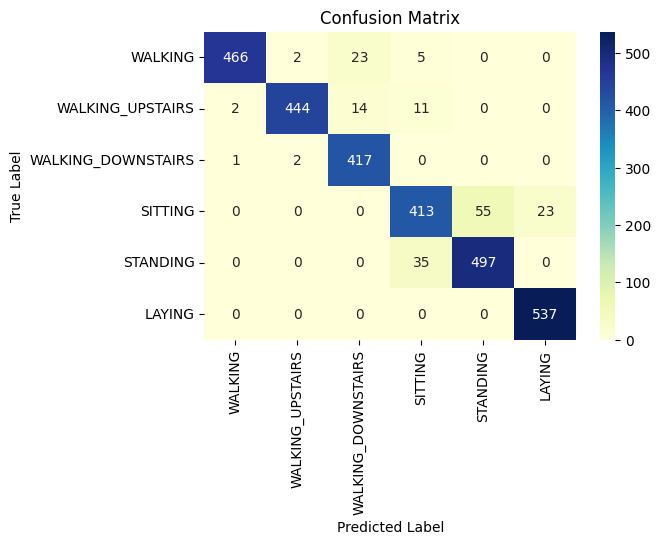

In [22]:
ypred_train = temporal_cbam.predict(trainX.reshape(-1, 32*4, 9))
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = temporal_cbam.predict(testX.reshape(-1, 32*4, 9))
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### CBAM with ConvLSTM

In [32]:
from keras.layers import Lambda

# Assuming CBAM is already defined correctly
def conv_lstm_with_cbam(input_shape, n_outputs):
    inputs = Input(shape=input_shape)

    # Apply Conv1D and CBAM layer independently to each time step
    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))(inputs)
    
    # Use Lambda layer to apply CBAM at each time step
    x = TimeDistributed(Lambda(lambda x: CBAM()(x)))(x)

    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
    x = TimeDistributed(Flatten())(x)

    # Apply Bidirectional LSTM to the output of the TimeDistributed layers
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)
    output = Dense(n_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Example of calling the function
conv_lstm_cbam = conv_lstm_with_cbam(input_shape=(4, 32, 9), n_outputs=6)
conv_lstm_cbam.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 4, 32, 9)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 4, 32, 64)      │         1,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 4, 32, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 4, 16, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 4, 2048)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,710 (8.64 MB)

 Trainable params: 2,264,710 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# history=temporal_cbam.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=1)

In [ ]:
loss , accuracy = adapt_rnn.evaluate(testX, testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

In [ ]:
ypred_train = adapt_rnn.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = adapt_rnn.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()